In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Read log files

In [66]:
#directory = os.path.join(os.getcwd(), 'run_statistics/')
#directory = '/t1-data/user/asmith/Projects/capturec_dev/capturec_test_run_nc_Hex/run_statistics/'
directory = '/t1-data/user/asmith/Projects/capturec_dev/capturec_mo/asmith_pipeline/run_statistics/'

# Initial duplication statistics

Shows the results of the initial deduplication (based only on exact sequence matches).

In [87]:
df = pd.read_csv(directory + 'deduplication_stats.tsv', sep='\t', index_col=0)

In [88]:
df_melt = (df.reset_index()
             .drop(columns='Read_pairs_processed')
             .melt(id_vars=['index'], var_name='stat', value_name='count')
             .rename(columns={'index': 'sample'})
             .assign(sample=lambda df: df['sample'])
             .sort_values(['sample', 'stat']))

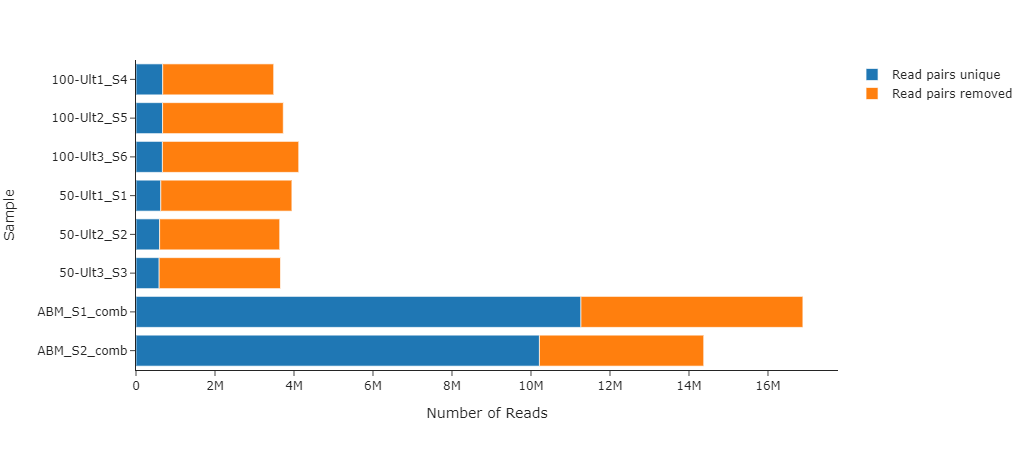

In [90]:
fig = px.bar(data_frame=df_melt,
       x='count',
       y='sample',
       color='stat',
       template='simple_white',
       category_orders={'sample': sorted(df_melt['sample'].unique()),
                        'stat': ['Read_pairs_unique', 'Read_pairs_removed']})
fig.for_each_trace(lambda t: t.update(name=' '.join(t.name.split('_'))))
fig.update_layout(legend_title_text='')
fig.update_yaxes(title='Sample')
fig.update_xaxes(title='Number of Reads')

# Read pair combination statistics (FLASh)

Shows the number of read pairs combined by FLASh

In [70]:
df = pd.read_csv(directory + 'combined_stats.tsv', sep='\t', index_col=0)
df = df.loc[lambda df: df['stat_type'].isin(['Flashed or unflashed'])]
df['read_type'] = df['read_type'].str.capitalize().str.replace('Pe', 'Paired-end (not-combined)')

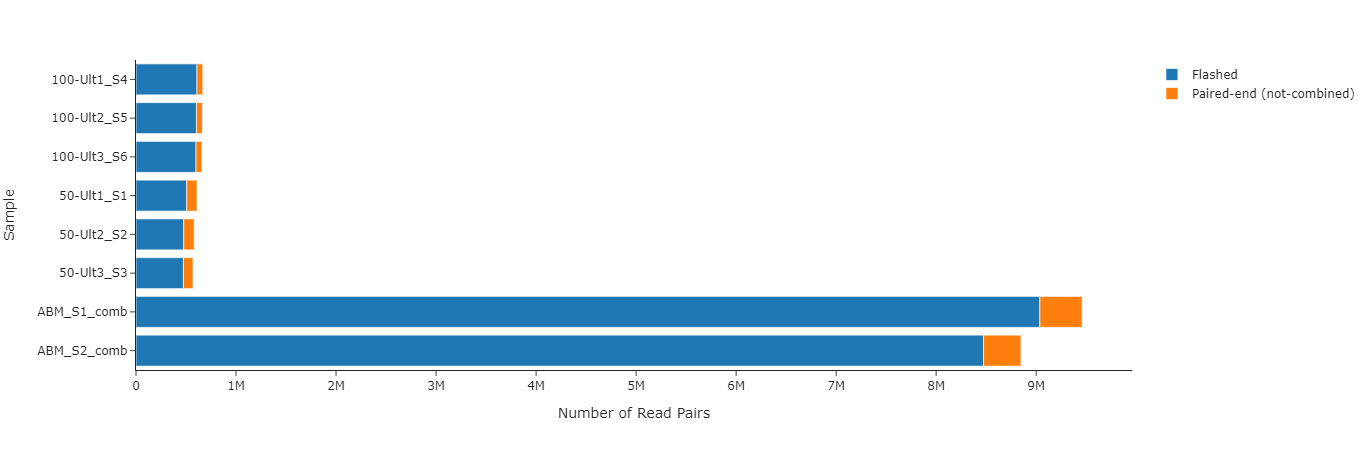

In [71]:
fig = px.bar(data_frame=df,
             x='read_pairs',
             y='sample',
             color='read_type',
             template='simple_white',
             category_orders={'sample': sorted(df['sample'])})
fig.update_layout(legend_title_text='')
fig.update_yaxes(title='Sample')
fig.update_xaxes(title='Number of Read Pairs')

# Fastq *in silico* digestion statistics


In [72]:
df = pd.read_csv(directory + 'digestion_stats.tsv', sep='\t', index_col=0)

In [73]:
df['n_slices'] = df['frequency'] * df['bin']
df_summarise = (df.groupby(['sample', 'read_type', 'stat'])
                  ['n_slices']
                  .sum()
                  .reset_index()
                  .assign(read_type=lambda df: df['read_type'].str.replace('r1', 'read_1').str.replace('r2', 'read_2').str.capitalize(),
                          stat=lambda df: df['stat'].str.capitalize(),
                          )
                )

## Read pairs with valid slices

Total slices contains all processed reads

Valid slices have been filtered by read length (default >= 18 bp) and Flashed reads are excluded if they do not contain a Restriction Site.

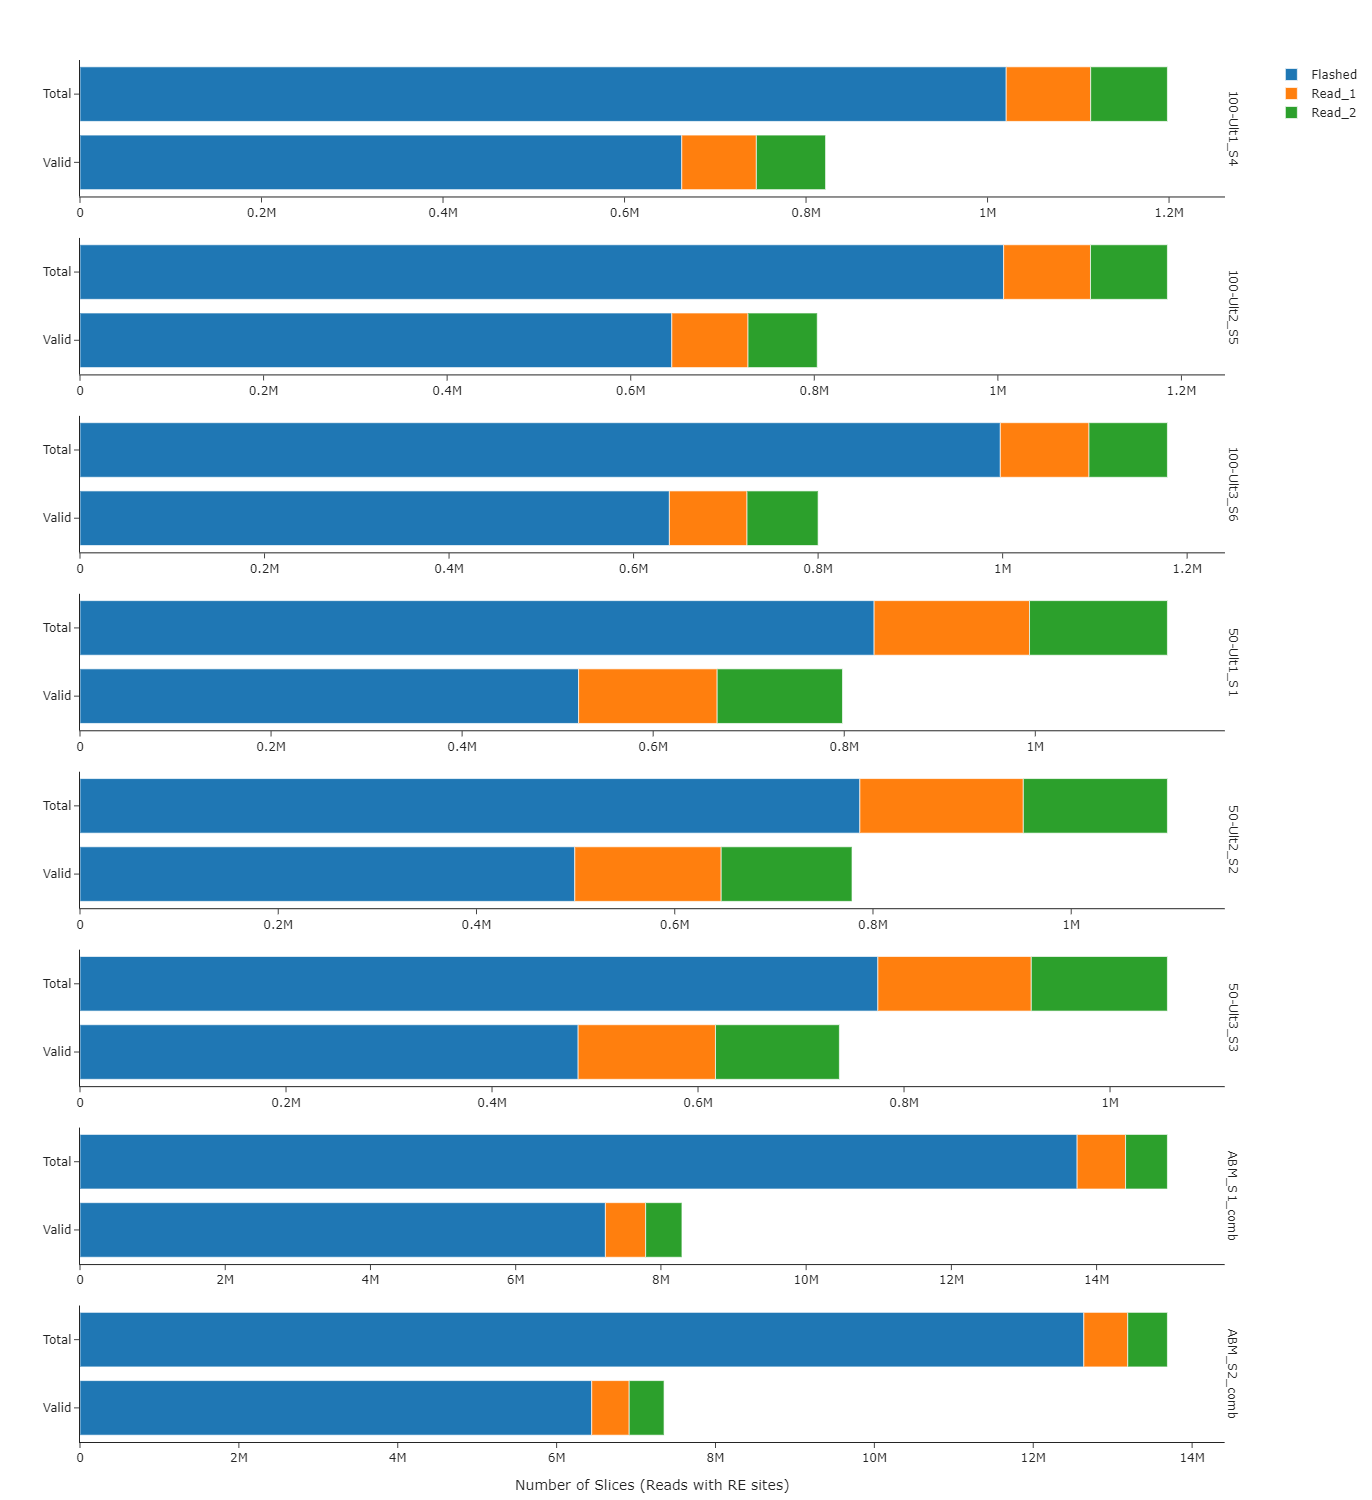

In [74]:
fig = px.bar(data_frame=df_summarise,
             x='n_slices',
             y='stat',
             color='read_type',
             facet_row='sample',
             template='simple_white',
             category_orders={'stat': ['total', 'valid'],
                              'sample': sorted(df_summarise['sample'])},
             height=1500,
             width=750)
fig.update_layout(legend_title_text='', 
                  margin={'b': 10},
                  )
fig.update_yaxes(title='', autorange='reversed')
fig.update_xaxes(matches=None, showticklabels=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.layout['xaxis']['title']['text'] = 'Number of Slices (Reads with RE sites)'
fig

## Histogram of digested slices

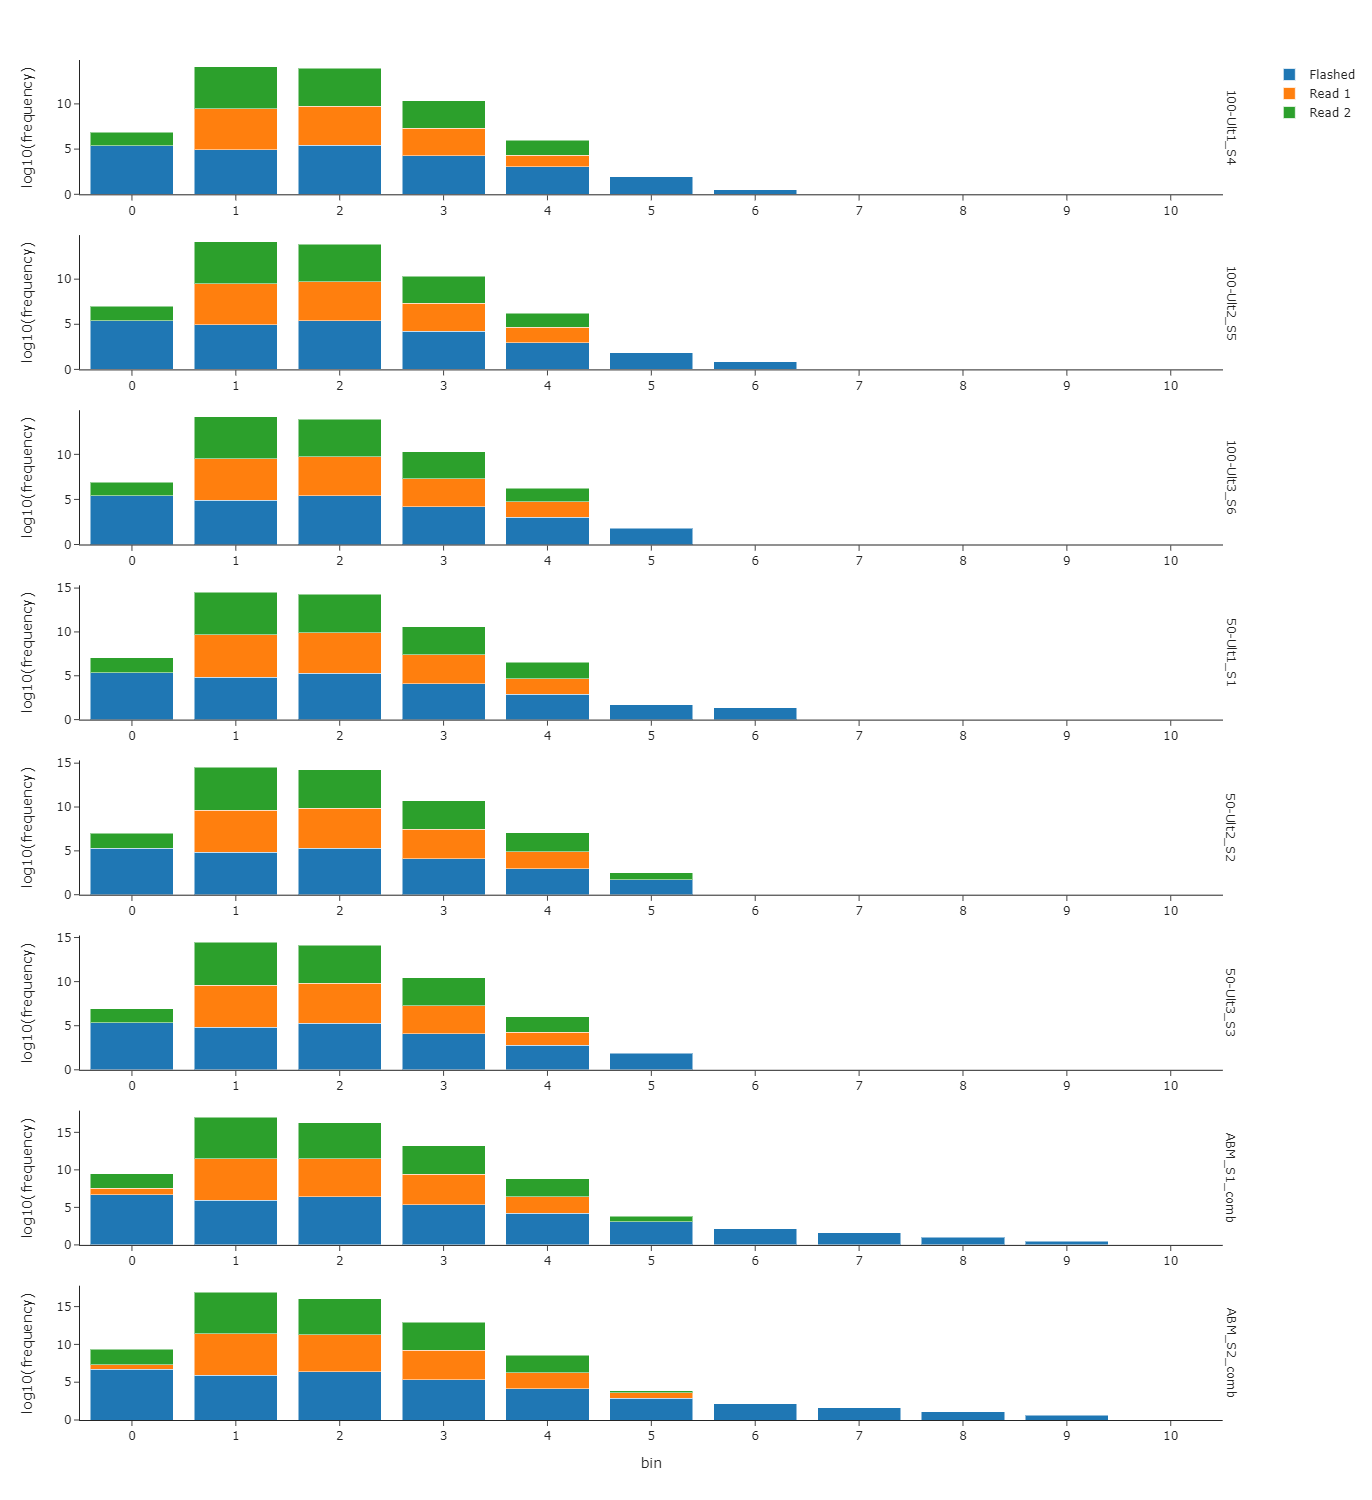

In [75]:
df_hist = (df.loc[lambda df: df['stat'] == 'valid']
             [['sample', 'bin', 'read_type', 'frequency']]
             .assign(log10_count=lambda df: np.log10(df['frequency'] + 1e-12),
                     read_type=lambda df: df['read_type'].str.replace('r1', 'read 1').str.replace('r2', 'read 2').str.capitalize())
          )

fig = px.bar(data_frame=df_hist,
             x='bin',
             y='log10_count',
             color='read_type',
             facet_row='sample',
             template='simple_white',
             barmode='stack',
             height=1500,
             width=750,
             category_orders={'sample': sorted(df_hist['sample'])})

fig.update_layout(legend_title_text='')
fig.update_yaxes(title='log10(frequency)', matches=None, showticklabels=True)
fig.update_xaxes(dtick=1, showticklabels=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))

# CCanalyser_statistics

Summary statistics from ccanalyser, summarised per read pair

In [76]:
df = pd.read_csv(directory + 'ccanalyser_stats.tsv', sep='\t', index_col=0)

In [77]:
df = df.reset_index().rename(columns={'index': 'filtering_step'})
df['sample'] = df['filtering_step'].str.split('|').str[0]
df['read_type'] = df['filtering_step'].str.split('|').str[1].str.capitalize().str.replace('Pe', 'Paired-end')
df['filter'] = df['filtering_step'].str.split('|').str[2].str.capitalize().str.split('_').str.join(' ')

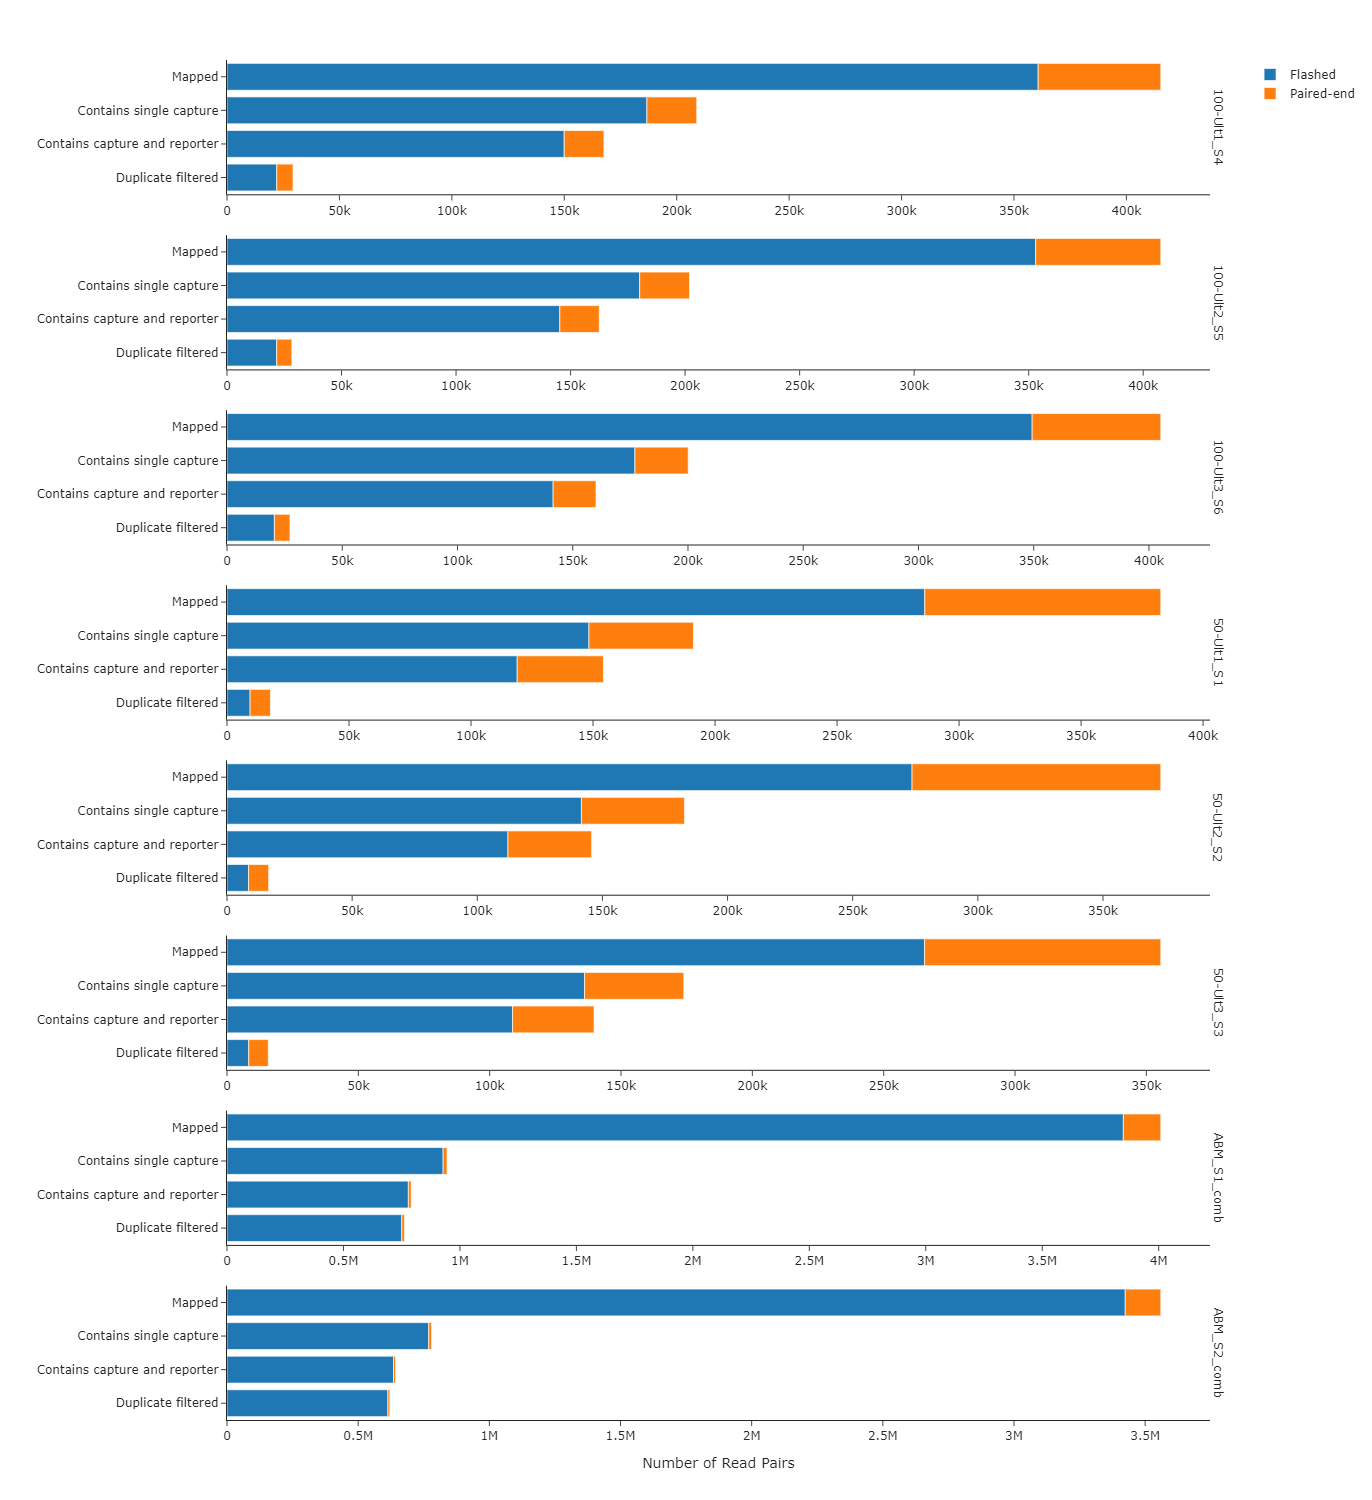

In [78]:
fig = px.bar(data_frame=df,
             x='unique_fragments',
             y='filter',
             template='simple_white',
             color='read_type',
             facet_row='sample',
             category_orders={'filter': ['Mapped', 'Contains single capture', 'Contains capture and reporter', 'Duplicate filtered']},
             height=1500,
             width=1000)
fig.update_yaxes(title_text='')
fig.update_xaxes(matches=None, showticklabels=True)
fig.for_each_trace(lambda t: t.update(name=t.name.split('=')[0]))
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.update_layout(legend_title_text='')
fig.layout['xaxis_title_text'] = 'Number of Read Pairs'
fig

## Capture and reporter statistics

Number of Cis/Trans reporters identified for each capture probe.

In [79]:
df = pd.read_csv(f'{directory}/reporter_stats.tsv', sep='\t', index_col=0)
df = df.groupby(['sample','capture_probe', 'cis/trans']).sum().reset_index()

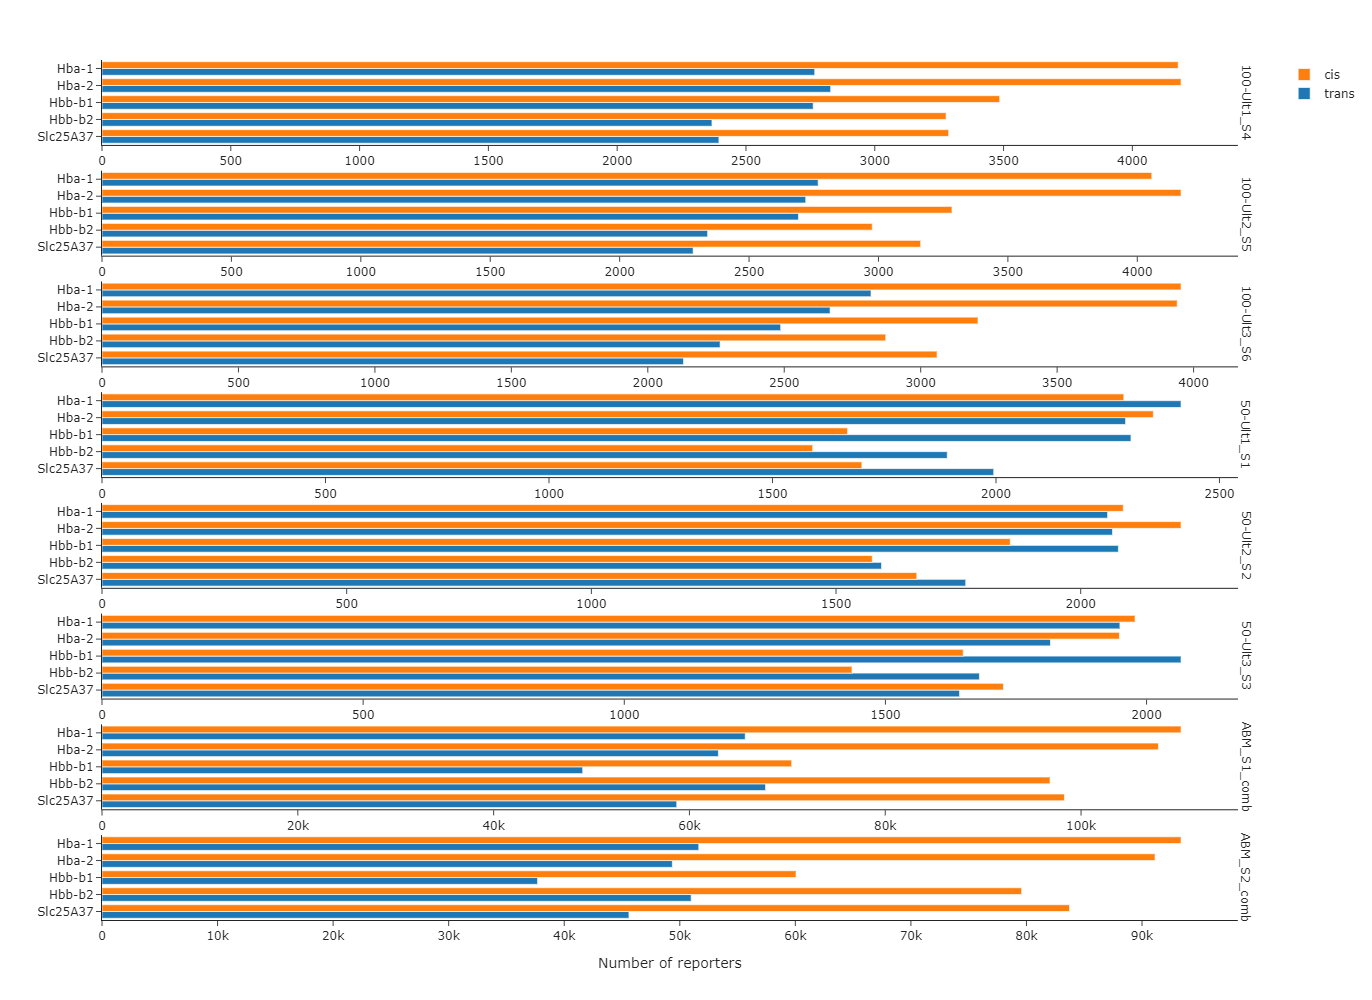

In [80]:
n_samples = df['sample'].unique().shape[0]
n_probes = df['capture_probe'].unique().shape[0]
fig = px.bar(data_frame=df,
             x='count',
             y='capture_probe',
             color='cis/trans',
             facet_row='sample',
             barmode='group',
             template='simple_white',
             category_orders={'cis/trans': ['trans', 'cis'],
                              'capture_probe': sorted(df['capture_probe'].unique()),
                              'sample': sorted(df['sample'].unique())},
             height=n_samples * n_probes * 25,
             width=1000,
             labels={'count': 'Number of reporters'})
fig.update_yaxes(title_text='')
fig.update_xaxes(matches=None, showticklabels=True)
fig.for_each_trace(lambda t: t.update(name=t.name.split('=')[0]))
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.update_layout(legend={'traceorder':'reversed', 'title': ''})

# Overall stats

Combined statistics from the entire run summarised for each read pair.

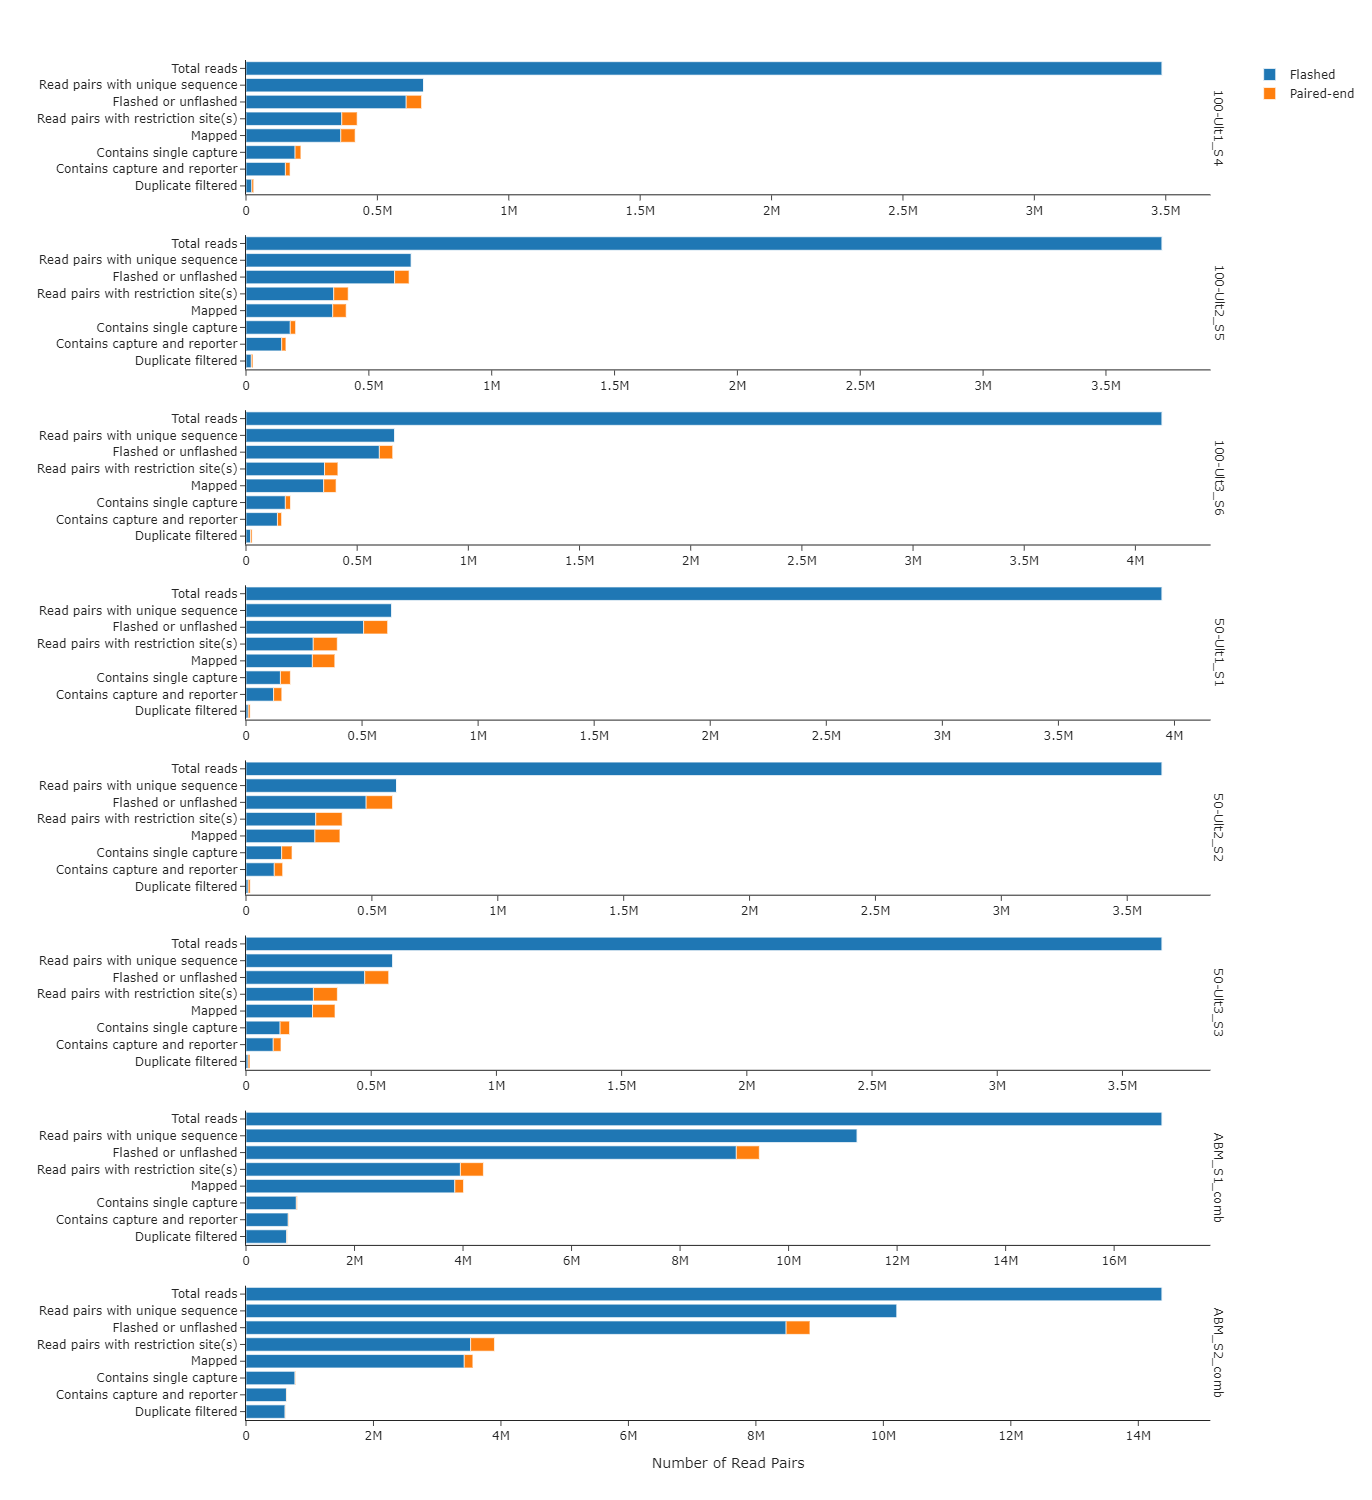

In [81]:
df = pd.read_csv(directory + 'combined_stats.tsv', sep='\t', index_col=0)
df = df.assign(read_type=lambda df: df['read_type'].str.capitalize().str.replace('Pe', 'Paired-end'))

fig = px.bar(df,
             x='read_pairs',
             y='stat_type',
             color='read_type',
             template='simple_white',
             facet_row='sample',
             height=1500,
             width=1000,
             )
fig.update_yaxes(autorange='reversed', title_text='')
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_layout(legend_title_text='')
fig.for_each_annotation(lambda a: a.update(text=f'{a.text.split("=")[1]}'))
fig.layout['xaxis']['title_text'] = 'Number of Read Pairs'
fig